In [ ]:
# default_exp funcs.visualization

In [ ]:
%load_ext autoreload
%autoreload 2

# Visualization tools 

In [ ]:
#export
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.evaluation import *
from decode_fish.funcs.plotting import *
from torch.utils.data import DataLoader
from decode_fish.engine.microscope import Microscope
from decode_fish.engine.point_process import PointProcessUniform

import ipyvolume as ipv

base_path =  '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/'

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [ ]:
cfg = OmegaConf.load('../config/experiment/sim_density_fac1_c1.yaml')
# cfg.dataloader.bs = 1
# cfg.random_crop.crop_sz = 48
model = hydra.utils.instantiate(cfg.model)
post_proc = hydra.utils.instantiate(cfg.post_proc_isi)
# model = load_model_state(model, cfg.output.save_dir, 'model.pkl')
psf, noise, micro = load_psf_noise_micro(cfg)
# psf.load_state_dict(torch.load(Path(cfg.output.save_dir)/'psf.pkl'))

In [ ]:
img_3d, decode_dl = get_dataloader(cfg)

20 volumes


In [ ]:
# export
def get_simulation_statistics(decode_dl, micro, int_threshold=1, samples = 1):
    
    """
    Draws a sample from the dataloader, and plots a slice of the real volume, the extracted background and
    a slice from a simulated volume.

        
    """ 
    z_ind = decode_dl.dataset.dataset_tfms[0].crop_sz[0]//2
    with torch.no_grad():
        
        for _ in range(samples):
        
            xmax = 0
            while xmax < int_threshold:
                x, local_rate, background = next(iter(decode_dl))
                xmax = x[0,0,z_ind].max()
                
            sim_vars = PointProcessUniform(local_rate, micro.int_mu.detach(), micro.int_scale.detach(), micro.int_loc.detach(), sim_iters=5).sample()  
            xsim = micro(*sim_vars)
            xsim = micro.noise(xsim, background).sample()
            sim_df = sample_to_df(*sim_vars[:-1])
            sim_df = sim_df[sim_df['frame_idx'] == 0]
            
            fig, axes = plt.subplots(ncols=3, figsize=(15,5))
            fig.suptitle('z slice')
            
            x = cpu(x[0,0])
            xsim = cpu(xsim[0,0])
            
            im = axes[0].imshow(x[z_ind])
            add_colorbar(im)
            axes[0].set_title('Recording')

            im = axes[1].imshow(cpu(background[0,0])[z_ind])
            add_colorbar(im)
            axes[1].set_title('Background')

            im = axes[2].imshow(xsim[z_ind])
            add_colorbar(im)
            axes[2].set_title('Simulation')

            axes = plot_3d_projections(x, 'max')
            axes[1].set_title('Recording, max proj')
            
            axes = plot_3d_projections(xsim, 'max')
            axes[1].set_title('Simulation, max proj')

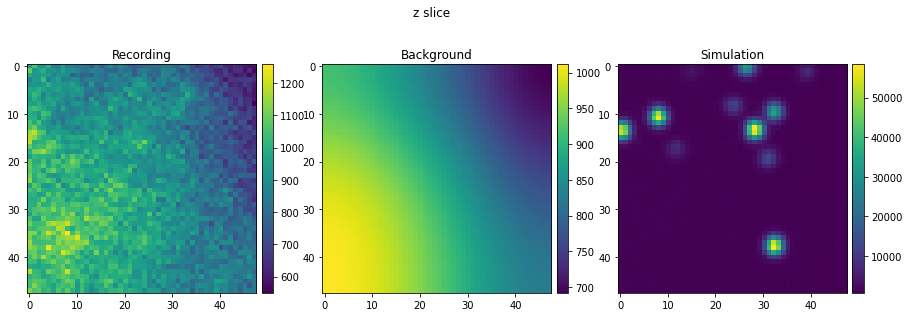

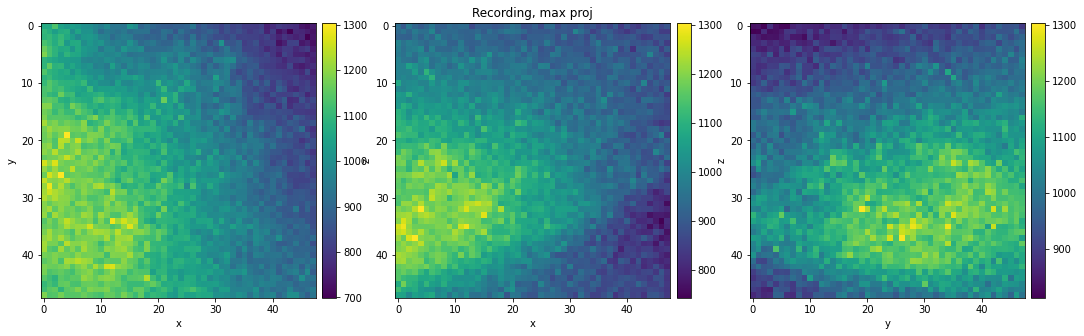

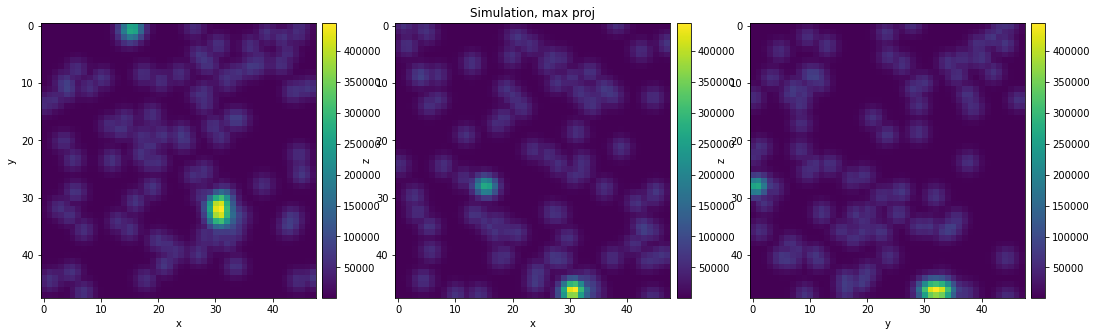

In [ ]:
get_simulation_statistics(decode_dl, micro, samples=1)

In [ ]:
# export
def get_prediction(model, post_proc, img, micro=None, cuda=True, return_rec=False, min_int=-1000.):
    
    with torch.no_grad():
        
        img = img[(None,)*(5-img.ndim)]
        model.eval().cuda() if cuda else model.eval().cpu()
        res_dict = model(img.cuda()) if cuda else model(img)
        pred_df = post_proc(res_dict)
        pred_df = pred_df[pred_df['int'] > min_int]

        if return_rec:
            locations, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape = post_proc(res_dict, ret='micro')[:6]
            inds = torch.where(ints_3d > min_int)[0]
            ae_img_3d = micro([l[inds] for l in locations], x_os_3d[inds], y_os_3d[inds], z_os_3d[inds], ints_3d[inds], output_shape)   
            return pred_df, ae_img_3d + res_dict['background'], res_dict
            
        return pred_df

def eval_random_crop(decode_dl, model, post_proc, micro, projection='mean', cuda=False, samples=1, int_threshold=1):
    
    with torch.no_grad():
        
        for _ in range(samples):
        
            x = torch.zeros(1)
            while x.max() < int_threshold:
                x, local_rate, background = next(iter(decode_dl))
            pred_df, rec, res_dict = get_prediction(model, post_proc, x[:1], micro=micro, cuda=True, return_rec=True)
            pred_df = nm_to_px(pred_df, post_proc.px_size)

            x = x[0,0].cpu().numpy()
            rec = rec[0,0].cpu().numpy()

            axes = plot_3d_projections(x, projection=projection)
            axes[0].scatter(pred_df['x'],pred_df['y'], color='red', s=5.)
            axes[1].scatter(pred_df['x'],pred_df['z'], color='red', s=5.)
            axes[2].scatter(pred_df['y'],pred_df['z'], color='red', s=5.)

            axes[1].set_title('Predictions', size=16)

            diff = abs(x-rec)
            axes = plot_3d_projections(diff, projection=projection)
            rmse = np.sqrt(((diff)**2).mean())

            axes[1].set_title(f'Reconstruction {rmse:.2f}', size=16)
            
            pred_df, rec,res_dict
            
def eval_random_sim(decode_dl, model, post_proc, micro, projection='mean', plot_gt=True, cuda=True, samples=1):
    
    with torch.no_grad():
        
        for _ in range(samples):
        
            x, local_rate, background = next(iter(decode_dl))
            
            sim_vars = PointProcessUniform(local_rate).sample()
            xsim = micro(*sim_vars)
            x = micro.noise(xsim, background).sample()
            pred_df, rec, res_dict = get_prediction(model, post_proc, x[:1], micro=micro, cuda=True, return_rec=True)
            pred_df = nm_to_px(pred_df, post_proc.px_size)
            sim_df = nm_to_px(sample_to_df(*sim_vars[:-1]))
            sim_df = sim_df[sim_df['frame_idx']==0]

            x = x[0,0].cpu().numpy()
            rec = rec[0,0].cpu().numpy()

            axes = plot_3d_projections(x, projection=projection)
            
            if plot_gt:
                axes[0].scatter(sim_df['x'],sim_df['y'], color='black', marker='x', s=25.)
                axes[1].scatter(sim_df['x'],sim_df['z'], color='black', marker='x', s=25.)
                axes[2].scatter(sim_df['y'],sim_df['z'], color='black', marker='x', s=25.)
            
            axes[0].scatter(pred_df['x'],pred_df['y'], color='red', s=5.)
            axes[1].scatter(pred_df['x'],pred_df['z'], color='red', s=5.)
            axes[2].scatter(pred_df['y'],pred_df['z'], color='red', s=5.)

            axes[1].set_title('Predictions', size=16)

            axes = plot_3d_projections(rec, projection=projection)

            axes[1].set_title(f'Reconstruction', size=16)

In [ ]:
eval_random_sim(decode_dl, model, post_proc, micro, projection='max', samples=3)

TypeError: unsupported operand type(s) for -: 'Tensor' and 'NoneType'

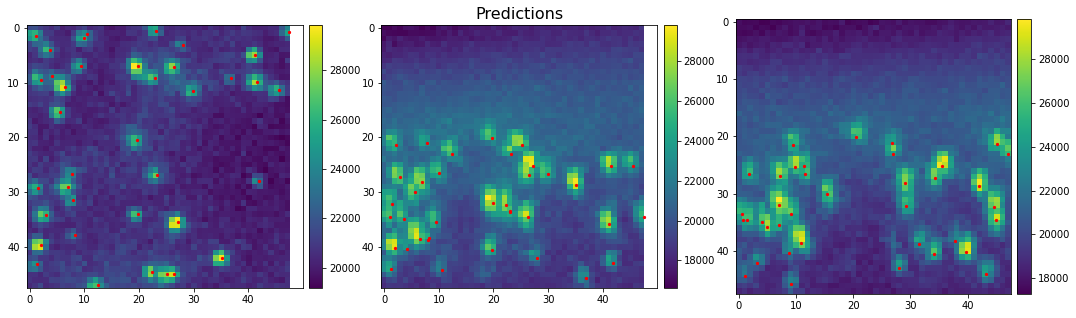

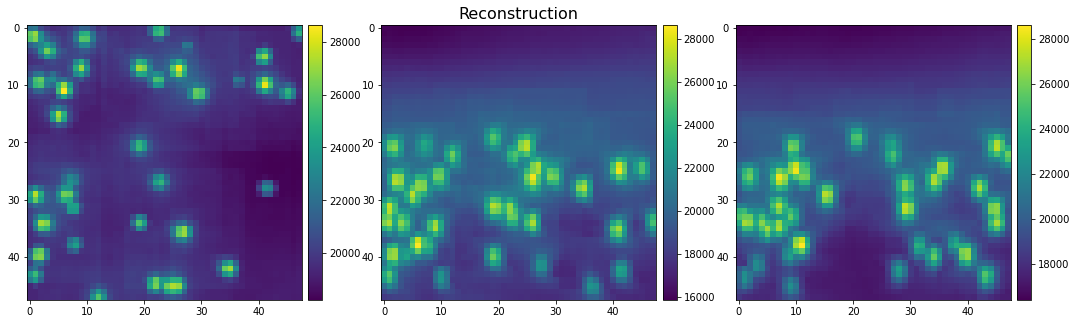

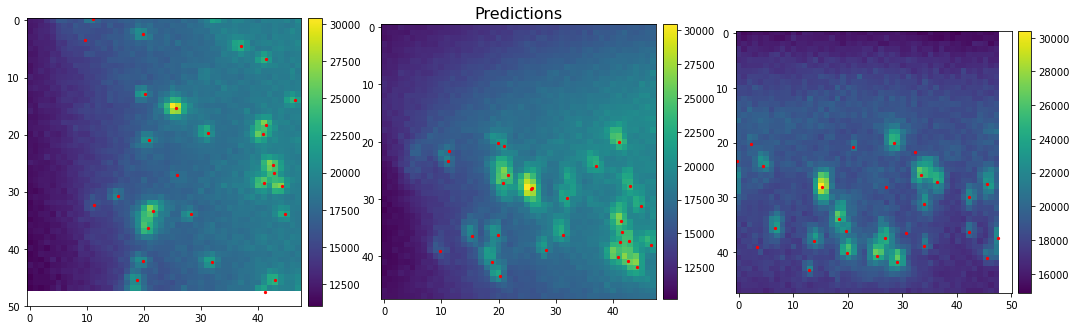

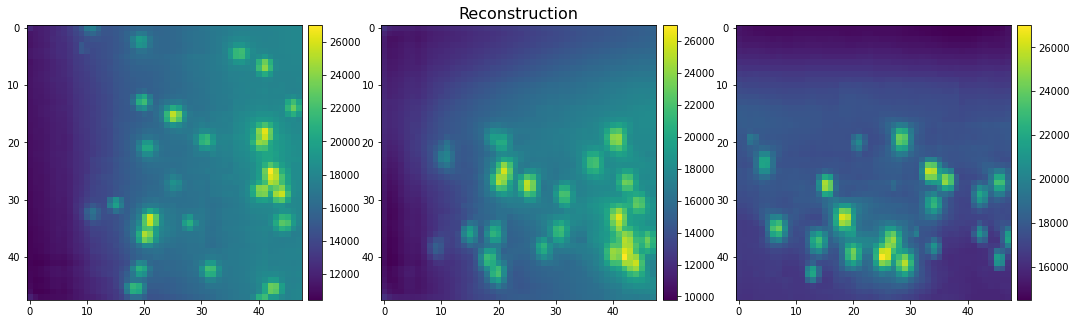

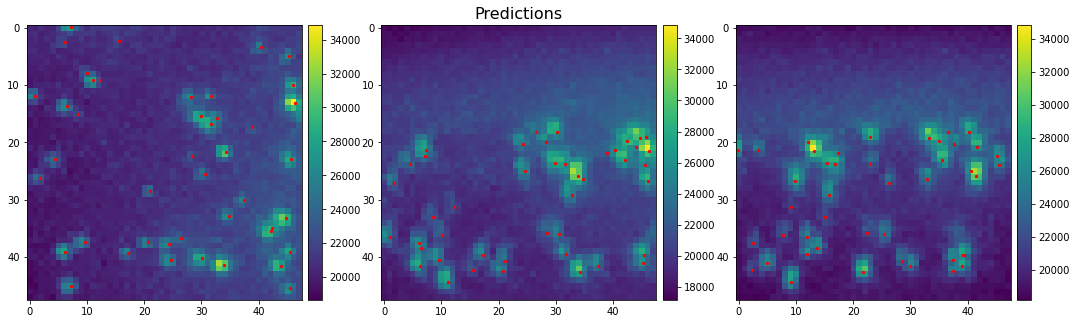

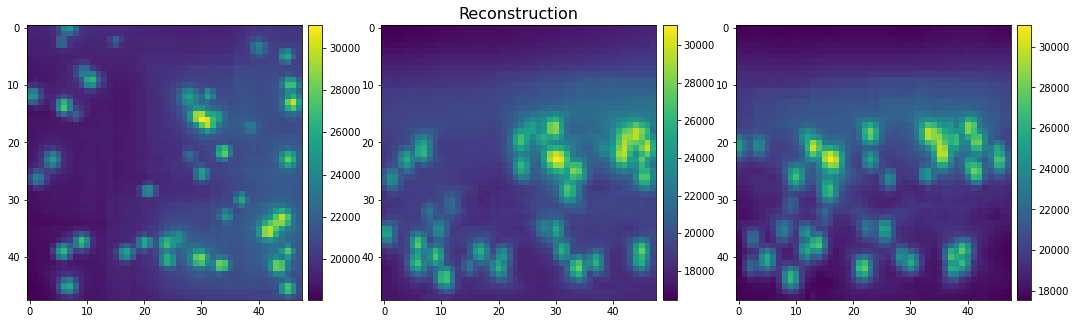

In [ ]:
eval_random_crop(decode_dl, model, micro, projection='max', threshold=0.1, samples=3)

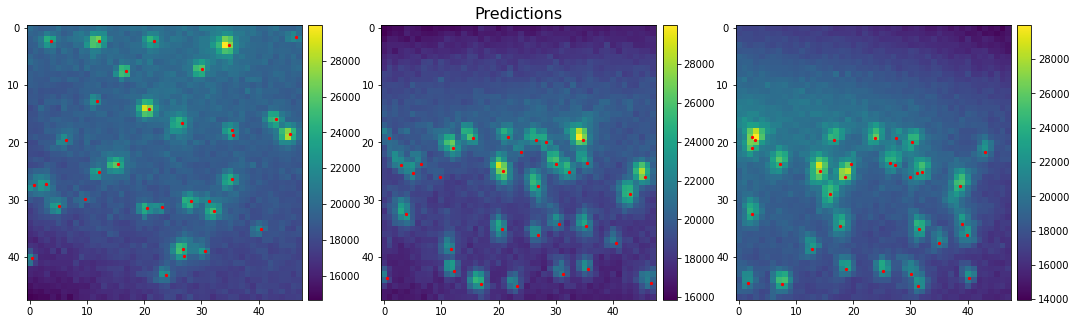

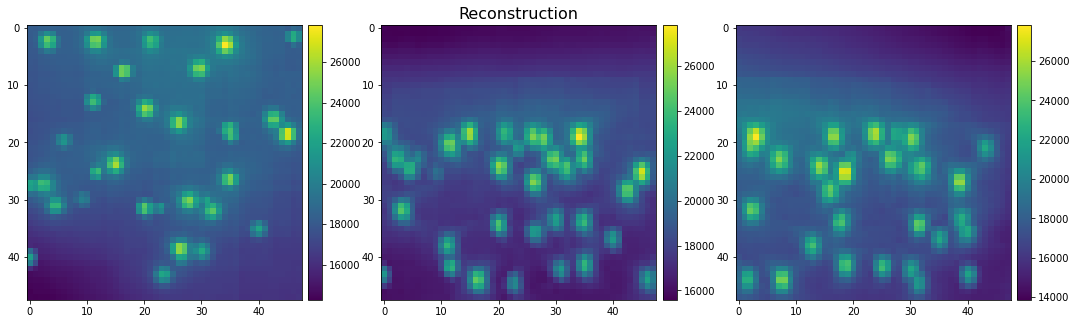

In [ ]:
projection='max'
px_size=np.array([100.,100.,100.])
cuda=False 
threshold=0.1
samples=1
    
with torch.no_grad():

    for _ in range(samples):

        x, local_rate, background = next(iter(decode_dl))

        sim_vars = PointProcessUniform(local_rate, min_int=decode_dl.min_int).sample()
        xsim = micro(*sim_vars)
        xsim = micro.noise(xsim, background).sample()

        pred_df, rec = get_prediction(model, x[:1], micro=micro, cuda=True, return_rec=True, threshold=threshold)
        pred_df = nm_to_px(pred_df, px_size)

        x = x[0,0].cpu().numpy()
        xsim = xsim[0,0].cpu().numpy()
        rec = rec[0,0].cpu().numpy()

        axes = plot_3d_projections(x, projection=projection)
        axes[0].scatter(pred_df['x'],pred_df['y'], color='red', s=5.)
        axes[1].scatter(pred_df['x'],pred_df['z'], color='red', s=5.)
        axes[2].scatter(pred_df['y'],pred_df['z'], color='red', s=5.)

        axes[1].set_title('Predictions', size=16)

        axes = plot_3d_projections(rec, projection=projection)

        axes[1].set_title('Reconstruction', size=16)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

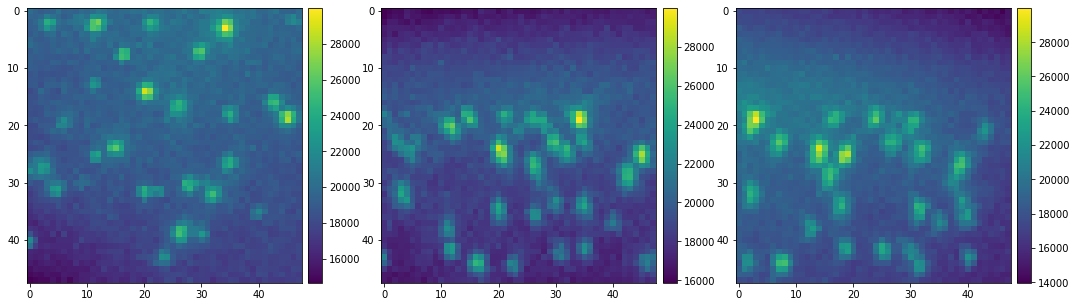

In [ ]:
plot_3d_projections(x,'max')

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

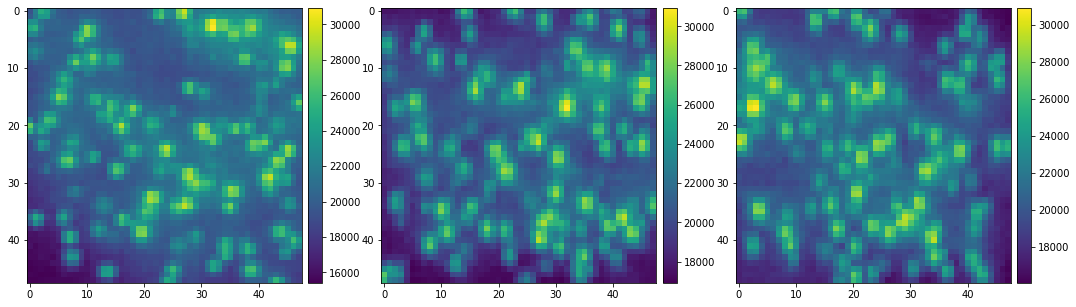

In [ ]:
plot_3d_projections(xsim, 'max')

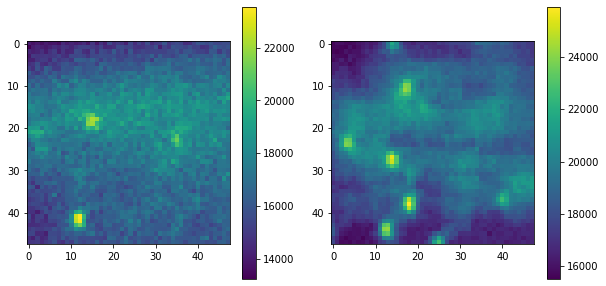

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(x[:,25])
plt.colorbar()
plt.subplot(122)
plt.imshow(xsim[:,18])
plt.colorbar()

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted index.ipynb.
